In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

To explore time series models, we will continue with the Rossmann sales data. This dataset has sales data for sales at every Rossmann store for a 3-year period, as well indicators of holidays and basic store information.



In [12]:
import pandas as pd

# Load the data and set the DateTime index, Note that you can now provide columns that are dates
# e.g. , parse_dates=["Date"]
data = pd.read_csv('./assets/dataset/rossmann.csv', skipinitialspace=True)

data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


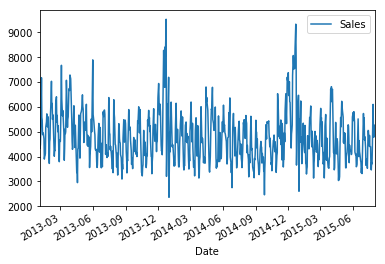

In [13]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filter to Store 1
store1_data = data[data.Store == 1]

# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]

# Plot the sales over time
store1_open_data[['Sales']].plot()

/Users/dylansorman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  This is separate from the ipykernel package so we can avoid doing imports until


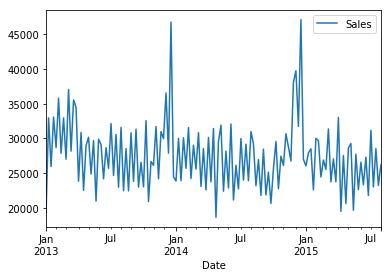

In [4]:
# Resampling to get a bigger picture view of total weekly sales vs. daily

store1_weekly_sales = data[data.Store == 1][['Sales']].resample('W', 'sum')
store1_weekly_sales.plot()

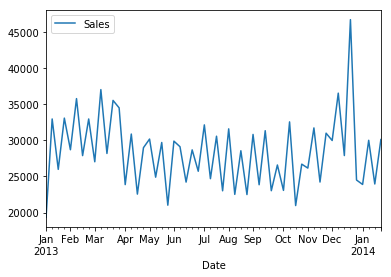

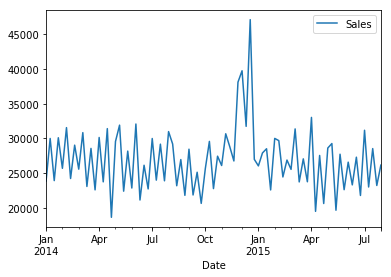

In [5]:
# Cut the data based on date range and plot
half_date_range = store1_weekly_sales["2013-01":"2014-01"]
rest = store1_weekly_sales["2014-01":]
half_date_range.plot()
rest.plot()

**Check** Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. Will we be able to use a predictive model - particularly an autoregressive one?

In [6]:
store1_data.Sales.autocorr(lag=1) # -0.12

-0.12732514339140219

In [7]:
store1_data.Sales.autocorr(lag=2) # -0.03

-0.034787155707946972

Pandas and statsmodels both provide convenience plots for autocorrelations.

/Users/srikanajan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[0, 21, -1, 1]

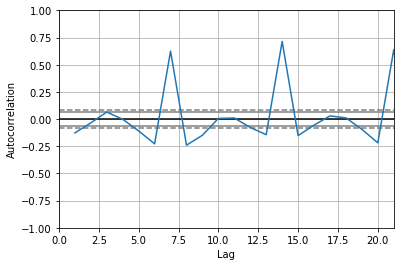

In [8]:
from pandas.tools.plotting import autocorrelation_plot

ax = autocorrelation_plot(store1_data.Sales)
ax.axis([0,21,-1,1])

#### Do you notice any patterns about where are the peaks in the autocorrelation plot?

/Users/srikanajan/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


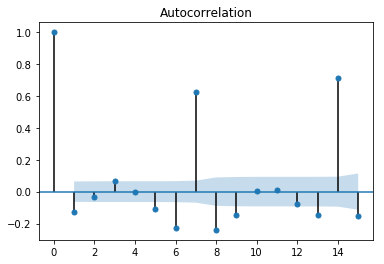

In [9]:
# Look at the plot as vertical line scatter plot.
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(store1_data.Sales, lags=15)
plt.show()

**Check**: What caused the spike at 7?

# Time Series Models. ARMA Model

Recall that `ARMA(p, q)` models are a sum of an `AR(p)` and a `MA(q)` model. So if we want just an `AR(p)` model we use and `ARMA(p, 0)` model. 

In [18]:
# Build a AR 1 MA 0 model
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)
model = ARMA(store1_sales_data, (1, 0)).fit()
print model.summary()

/Users/dylansorman/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Thu, 16 Nov 2017   AIC                          12540.651
Time:                        21:15:04   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4761.9579     82.984     57.384      0.000    4599.312    4924.604
ar.L1.Sales     0.6822      0.026     26.122      0.000       0.631       0.733
                                    Roots       

## Plotting residuals
Just like with other types of regression, we can compute the model residuals.

**Check**: What are residuals? In linear regression, what did we expect of residuals?

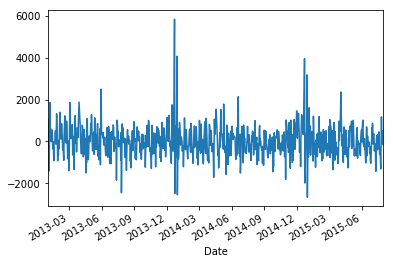

In [19]:
model.resid.plot()

In [20]:
plot_acf(model.resid)
plt.show()

NameError: name 'plot_acf' is not defined

In [ ]:
plot_pacf(model.resid, lags=50)
plt.show()

Becuase of the errors, it doesn't look like an AR model is good enough -- the data isn't stationary. So let's expand to an `ARMA` model.

In [ ]:
model = ARMA(store1_sales_data, (1, 1)).fit()
print model.summary()

In [21]:
from statsmodels.tsa.arima_model import ARIMA
# AR 2 and MA 2 model
model = ARIMA(store1_sales_data, (2, 0, 2)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 2)   Log Likelihood               -6243.725
Method:                       css-mle   S.D. of innovations            716.957
Date:                Thu, 16 Nov 2017   AIC                          12499.449
Time:                        21:15:05   BIC                          12527.413
Sample:                    07-31-2015   HQIC                         12510.204
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4760.7324     75.651     62.930      0.000    4612.458    4909.006
ar.L1.Sales    -0.2277      0.056     -4.064      0.000      -0.338      -0.118
ar.L2.Sales     0.4689      0.057      8.271    

### Calculate Mean Absolute Error as another Goodness of Fit metric for a specific date range

In [22]:
predictions = model.predict(
    "2015-06-02","2015-03-31",
    dynamic=False)

print("Mean absolute error: ", mean_absolute_error(store1_sales_data["2015-06-02":"2015-03-31"], predictions))

('Mean absolute error: ', 502.71893034296562)


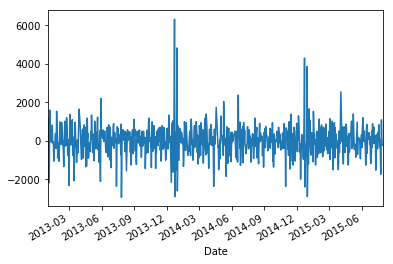

In [23]:
store1_sales_data.Sales.diff(1).autocorr(1) #-0.181

store1_sales_data.Sales.diff(1).plot()
plt.show()

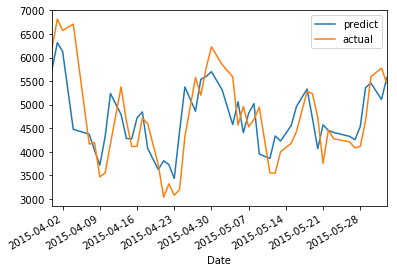

In [24]:
# Visualize the actual and prediction on the same plot
fig, axes = plt.subplots()
model.predict("2015-06-02","2015-03-31").plot(ax = axes)
store1_sales_data["2015-06-02":"2015-03-31"].plot(ax = axes)
plt.legend(["predict","actual"])

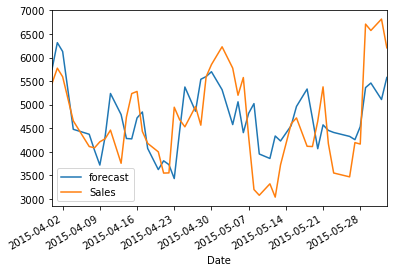

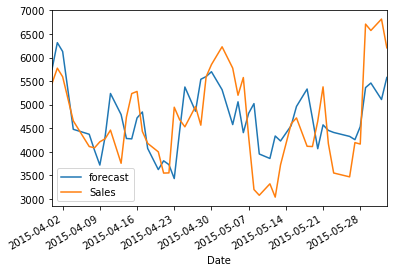

In [25]:
# Another way of plotting actual and prediction though its unclear why this is different than before
model.plot_predict("2015-06-02","2015-03-31")

In [26]:
# Another useful statistic is the Durbin Watson statistic to see if you have captured all the autocorrelation
# information in the model. If its close to 2, then the model has no autocorrelation
import statsmodels.api as sm
sm.stats.durbin_watson(model.resid.values)

2.0250090115557922